In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy import stats
from scipy.optimize import minimize, curve_fit
from scipy.special import erf # error function
from iminuit import Minuit

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

lower limit: 2000, upper limit: 8000


(2.0, 8.0)

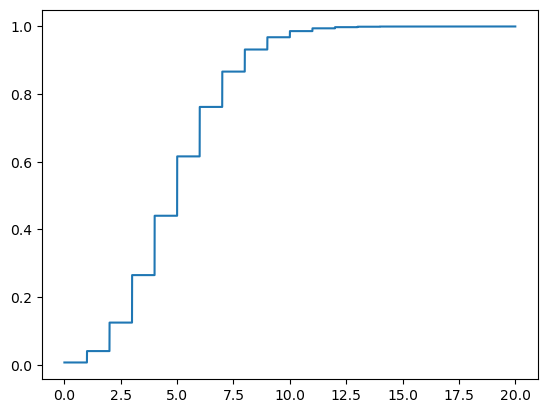

In [2]:
mu = 5

x = np.arange(0, 20, 1e-3)
cum_prob = stats.poisson.cdf(x, mu)

upper_limit = np.argmin(cum_prob<0.9)
lower_limit = np.argmin(cum_prob<0.1)

plt.plot(x, cum_prob)
print(f"lower limit: {lower_limit}, upper limit: {upper_limit}")
x[lower_limit], x[upper_limit]

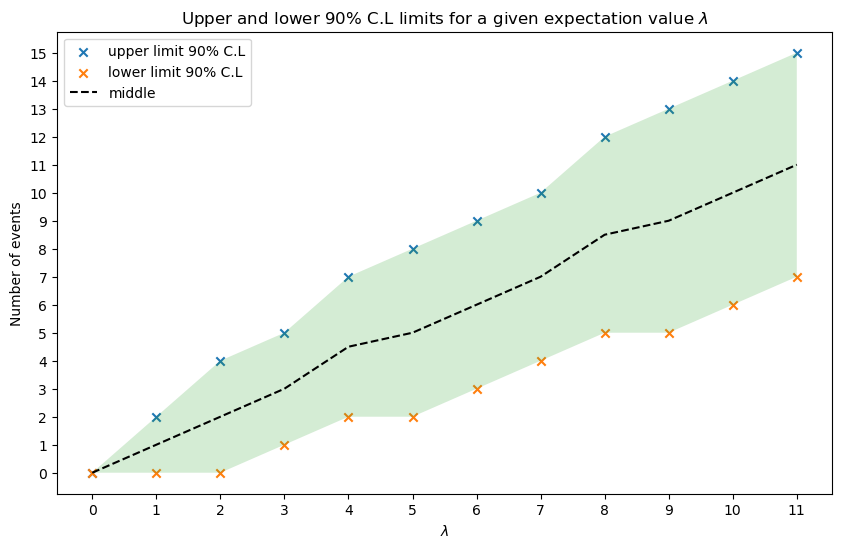

In [3]:
x = np.arange(0, 20, 1)
mu_array = np.arange(0, 12, 1)



uls = []
lls = []

for mu in mu_array:    
    cum_prob = stats.poisson.cdf(x, mu)
    upper_limit = x[np.argmin(cum_prob<0.9)]
    lower_limit = x[np.argmin(cum_prob<0.1)]
    uls.append(upper_limit)
    lls.append(lower_limit)

figure = plt.figure(figsize=(10, 6))

plt.scatter(mu_array, uls, label="upper limit 90% C.L", marker="x")
plt.scatter(mu_array, lls, label="lower limit 90% C.L", marker="x")
plt.plot(mu_array, np.sum([lls,uls],axis=0)/2, label="middle", ls="--", color="black")

plt.xticks(mu_array)
plt.yticks(x)

plt.fill_between(mu_array, uls, lls, alpha=0.2)
plt.legend()

plt.title("Upper and lower 90% C.L limits for a given expectation value $\lambda$")
plt.xlabel("$\lambda$")
plt.ylabel("Number of events")

plt.show()

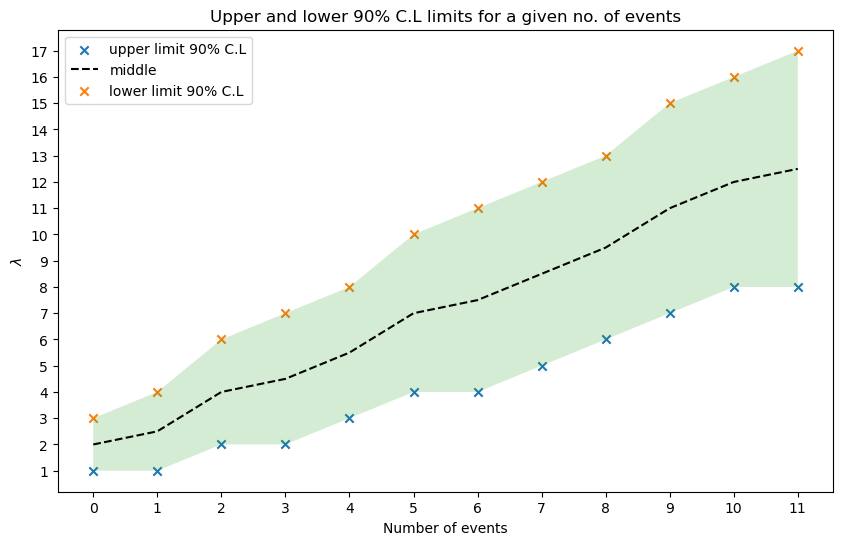

In [4]:
x = np.arange(0, 12, 1)
mu_array = np.arange(0, 18, 1)



uls = []
lls = []

for x_ in x:    
    cum_prob = stats.poisson.cdf(x_, mu_array)
    
    upper_limit = mu_array[np.argmax(cum_prob<0.9)]
    lower_limit = mu_array[np.argmax(cum_prob<0.1)]
    uls.append(upper_limit)
    lls.append(lower_limit)

figure = plt.figure(figsize=(10, 6))

plt.scatter(x, uls, label="upper limit 90% C.L", marker="x")
plt.plot(x, np.sum([lls,uls],axis=0)/2, label="middle", ls="--", color="black")
plt.scatter(x, lls, label="lower limit 90% C.L", marker="x")

plt.xticks(x)
plt.yticks(mu_array)


plt.fill_between(x, uls, lls, alpha=0.2)
plt.legend()
plt.title("Upper and lower 90% C.L limits for a given no. of events")
plt.xlabel("Number of events")
plt.ylabel("$\lambda$")
plt.show()

$$p(n;\lambda_{S};\lambda_{B})={\frac{\left(\lambda_{S}+\lambda_{B}\right)^{n}}{n!}}\exp\left(-\left[\lambda_{S}+\lambda_{B}\right]\right)$$

$$p(n\geq n_{o b s})=\sum_{n=n_{o b s}}^{\infty}p(n;\lambda_{S}=0;\lambda_{B})=1-\sum_{n=0}^{n_{o b s}-1}\frac{\lambda_{B}^{n}}{n!}\exp{(-\lambda_{B})}$$

As an example, assume a counting experiment in which 5 events are observed, while $λ_B$ = 1.8
background events are expected.

In [5]:
n_obs = 5
λ = 1.8

p_n_geq_n_obs = lambda n_obs, λ: 1 - stats.poisson.cdf(n_obs-1, λ)

p = p_n_geq_n_obs(n_obs, λ)

print(f"Probability of observing {n_obs} or more events: {p:.3f}")
print(f"significance of excess is: {stats.norm.ppf(1-p):.3f} sigma")


Probability of observing 5 or more events: 0.036
significance of excess is: 1.794 sigma


Determine an upper limit λmax for the number of signal events at a 95% CL. Such a limit is defined by the expected number of signal events λmax where the probability of measuring nobs or fewer events reaches 5% assuming a Poisson statistic with mean λB +λmax S. To (numerically) find the answer, perform an interval search starting from the probabilities to observe nB + nmin and nB + nmax or less events. Stop the search when the uncertainty, i.e. the difference of the limits of the interval, is less than 10−5.

In [6]:
p_n_leq_n_obs = lambda n_obs, λ: stats.poisson.cdf(n_obs, λ)

λ_max_s = 3

while p_n_leq_n_obs(n_obs, λ+λ_max_s) > 0.05:
    λ_max_s *= 1+1e-4
    
print(f"λ_max_s: {λ_max_s:.3f}, p(n ≤ n_obs; λ_max): {p_n_leq_n_obs(n_obs, λ_max_s+λ):.3f}")

λ_max_s: 8.713, p(n ≤ n_obs; λ_max): 0.050


Verify the limit determined in above problem B.2 with toy Monte Carlo experiments. In each toy experiment generate a random number according to a Poisson distribution with a mean value of λB + λmax. Then count the number of experiments in which this random number is less or equal nobs. By construction, the fraction of these events should be 5%

In [7]:
n_sim = int(1e6) # 1 million simulations

n_samples = stats.poisson.rvs(λ+λ_max_s, size=n_sim)

count = np.sum(n_samples <= n_obs)
        
print(f"p(n ≤ n_obs; λ_max) from simulation: {count/n_sim:.3f}")

p(n ≤ n_obs; λ_max) from simulation: 0.050
